In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics
import warnings

In [3]:
PATH = "../data/bulldozers/"

In [23]:
warnings.filterwarnings('ignore')

In [ ]:
df_raw = pd.read_csv(f'{PATH}/train.csv', low_memory=False)

In [ ]:
df_raw.UsageBand

In [25]:
df_raw = pd.read_csv(f'{PATH}/train.csv', low_memory=False, parse_dates=['saledate'])

In [ ]:
df_raw.saledate

In [26]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [ ]:
display_all(df_raw.head().T)

In [27]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
# The following code is supposed to fail due to string values in the input data
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

In [ ]:
df_raw.saledate

In [28]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [ ]:
df_raw.head()

In [29]:
train_cats(df_raw)

In [ ]:
df_raw.UsageBand.cat.categories

In [30]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [31]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [ ]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [ ]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

In [32]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [12]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [ ]:
display_all(df.head())

In [33]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9831080567465541

In [34]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [35]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [36]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 9.71 s
[0.090403295529759, 0.2505037285693126, 0.9829193910124566, 0.8879333569614419]


In [21]:
?proc_df

In [37]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [38]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 375 ms
[0.11503478568576937, 0.3540629899063944, 0.9713683953766464, 0.7761232266728596]


In [39]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5293014432312495, 0.5801084173010085, 0.393831353538874, 0.39901129749627884]


In [40]:
??draw_tree

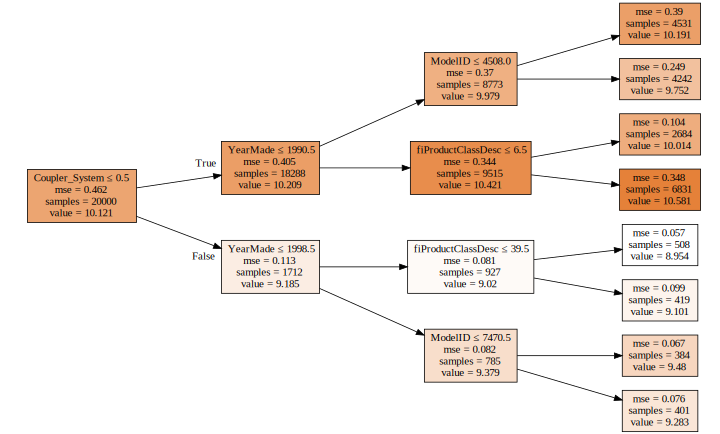

In [41]:
draw_tree(m.estimators_[0], df_trn, precision=3)